In [1]:
import os
import torch
import torchmetrics
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
from tqdm import tqdm
from model import ViT

# import importlib
# importlib.reload(ViT)

In [2]:
# train_transforms = transforms.Compose([
#     transforms.RandomRotation(degrees=30),
#     transforms.RandomResizedCrop(size=(28,28)),
#     transforms.ToTensor()
# ])

train_transforms = transforms.ToTensor()
validation_transforms = transforms.ToTensor()

train_dataset = MNIST(root="./mnist/", train=True, download=True, transform=train_transforms)
test_dataset = MNIST(root="./mnist/", train=False, download=True, transform=validation_transforms)

num_worker = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_worker)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_worker)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
lr = 5e-3

model = ViT(
    in_channels=1, 
    patch_size=4, 
    linear_Embed_size=8, 
    num_tr_encoders=4,
    num_msa_heads=2, 
    mlp_ratio=4,
    out_features=10 # MNIST classification
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
accuaracy = torchmetrics.Accuracy().to(device)

In [4]:
print(device)
pbar = tqdm(range(epochs))

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for epoch in pbar:
    # train
    model.train()
    loss_t = 0
    acc_t = 0
    for i,(X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        
        preds = model(X)
        loss = criterion(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_t += loss.detach().cpu().item()
        acc_t += accuaracy(preds, y).detach().cpu().item()

        pbar.set_postfix(
            {
                "epoch":f"{(epoch+1):02d}", 
                "mode":"train",
                "index":(i+1),
                "train_loss":f"{loss_t/(i+1):.3f}", 
                "train_acc":f"{acc_t/(i+1):.3f}"
            }
        )
    
    train_loss.append(loss_t/(i+1))
    train_acc.append(acc_t/(i+1))
    
    # eval
    model.eval()
    loss_v = 0
    acc_v = 0
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            preds = model(X)
            loss = criterion(preds, y)
        loss_v += loss.detach().cpu().item()
        acc_v += accuaracy(preds, y).detach().cpu().item()
        pbar.set_postfix(
            {
                "epoch":f"{(epoch+1):02d}", 
                "mode":"val",
                "index":(i+1),
                "val_loss":f"{loss_v/(i+1):.3f}", 
                "val_acc":f"{acc_v/(i+1):.3f}"
            }
        )
    
    test_loss.append(loss_v/(i+1))
    test_acc.append(acc_v/(i+1))

    # pbar.set_postfix({"epoch":f"{(epoch+1):02d}", "test_acc":f"{test_acc[-1]:.3f}", "train_acc":f"{train_acc[-1]:.3f}"})
        
    

cuda


100%|██████████| 20/20 [06:14<00:00, 18.74s/it, epoch=20, mode=val, index=79, val_loss=1.549, val_acc=0.911]       


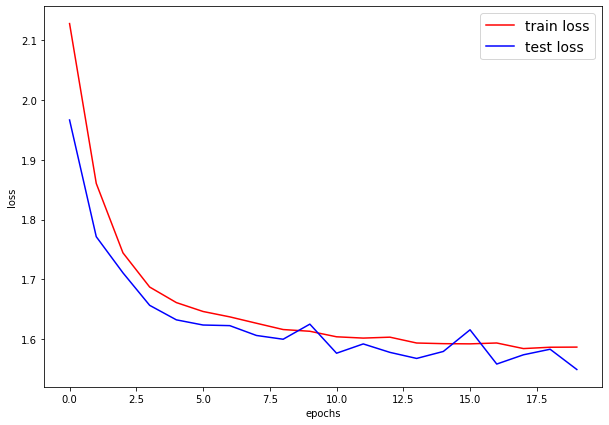

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.plot(train_loss, c='r', label="train loss")
plt.plot(test_loss, c='b', label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(prop={"size":14});

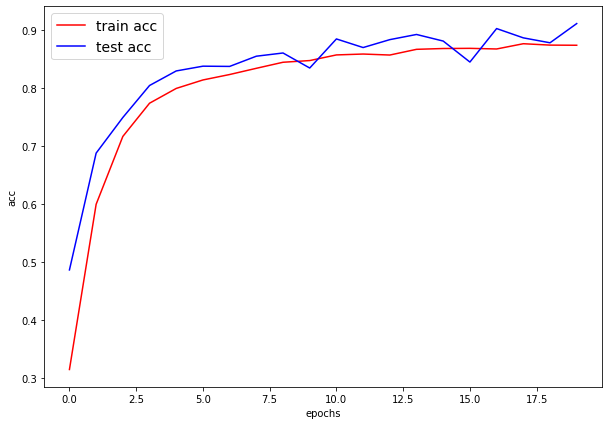

In [6]:
plt.figure(figsize=(10,7))

plt.plot(train_acc, c='r', label="train acc")
plt.plot(test_acc, c='b', label="test acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(prop={"size":14});

In [7]:
train_acc[-1], test_acc[-1]

(0.8740005330490405, 0.9113924050632911)

In [8]:
train_acc[4], test_acc[4]

(0.7995513503485397, 0.8297072784810127)